<a href="https://colab.research.google.com/github/young-hwanlee/stand_alone_deep_learning/blob/main/Assignment1_PyTorch_MNIST_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)
"""

'\n!pip install -q torch==1.0.0 torchvision\nimport torch\nprint(torch.__version__)\n'

In [2]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn

batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

50000 10000 10000


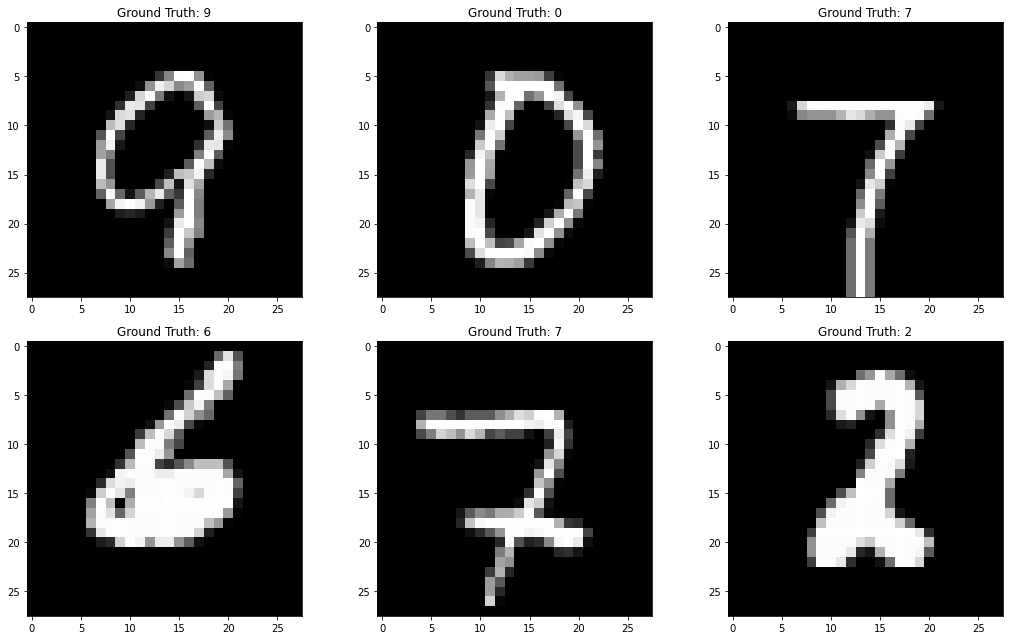

In [3]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)  

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

In [4]:
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=784, out_features=10, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

class MLPModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_nodes):
        super(MLPModel, self).__init__()
        nodes = (input_dim,) + hidden_nodes + (output_dim,)
        depth = len(nodes)
        linears = [nn.Linear(nodes[i], nodes[i+1]) for i in range(depth - 1)]
        self.linears = nn.ModuleList(linears)
        self.relu = nn.ReLU()
        self.depth = depth
    
    def forward(self, x):
        for linear in self.linears:
            x = self.relu(linear(x))
        return x

In [5]:
cls_loss = nn.CrossEntropyLoss()

In [8]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# ====== Construct Model ====== #
model = MLPModel(input_dim=784, output_dim=10, hidden_nodes=(1000, 1000))
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ===== Construct Optimizer ====== #
lr = 0.005 
optimizer = optim.SGD(model.parameters(), lr=lr) 

hist_epoch = [] 
hist_train_loss = []
hist_val_loss = []
hist_acc = []
hist_acc_epoch = []

epoch = 30
for i in range(epoch):
    
    # ====== Train ====== #
    train_loss = 0
    model.train() 
    
    for input_X, true_y in train_loader:
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.detach().numpy()

    train_loss = train_loss / len(train_loader)
    hist_train_loss.append(train_loss)
    hist_epoch.append(i)
    
    
    # ====== Validation ====== #
    val_loss = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Validation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
    
    with torch.no_grad(): # [21.01.05 코드 클린업] Validation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in val_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            pred_y = model(input_X)

            loss = cls_loss(pred_y.squeeze(), true_y)
            val_loss += loss.detach().numpy()

        val_loss = val_loss / len(val_loader)
        hist_val_loss.append(val_loss)


    # ====== Evaluation ======= #
    correct = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Evaluation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 

    with torch.no_grad(): # [21.01.05 코드 클린업] Evaluation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in test_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
            correct += pred_y.eq(true_y).sum()

        acc = correct.numpy() / len(test_loader.dataset)
        hist_acc.append(acc)
        hist_acc_epoch.append(i)
    
    print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%'.format(i, train_loss, val_loss, acc*100))

Number of 1796010 parameters
Epoch: 0, Train Loss: 1.6498410994439479, Val Loss: 1.0316479379617716, Test Acc: 79.03999999999999%
Epoch: 1, Train Loss: 0.8144216238690154, Val Loss: 0.7200325538840475, Test Acc: 82.01%
Epoch: 2, Train Loss: 0.6401324189075118, Val Loss: 0.621958739395383, Test Acc: 83.17999999999999%
Epoch: 3, Train Loss: 0.5702945322484312, Val Loss: 0.574086788334424, Test Acc: 83.95%
Epoch: 4, Train Loss: 0.44756903832830736, Val Loss: 0.3757970674505717, Test Acc: 90.32%
Epoch: 5, Train Loss: 0.3335907836170757, Val Loss: 0.33455926349645926, Test Acc: 91.13%
Epoch: 6, Train Loss: 0.3042485132775343, Val Loss: 0.3114371131869811, Test Acc: 91.72%
Epoch: 7, Train Loss: 0.28440211534195237, Val Loss: 0.29524465640888936, Test Acc: 92.34%
Epoch: 8, Train Loss: 0.2688943078107846, Val Loss: 0.2835418691363516, Test Acc: 92.83%
Epoch: 9, Train Loss: 0.2560437008395524, Val Loss: 0.27032493281213543, Test Acc: 93.02%
Epoch: 10, Train Loss: 0.2439649092305042, Val Loss: 0

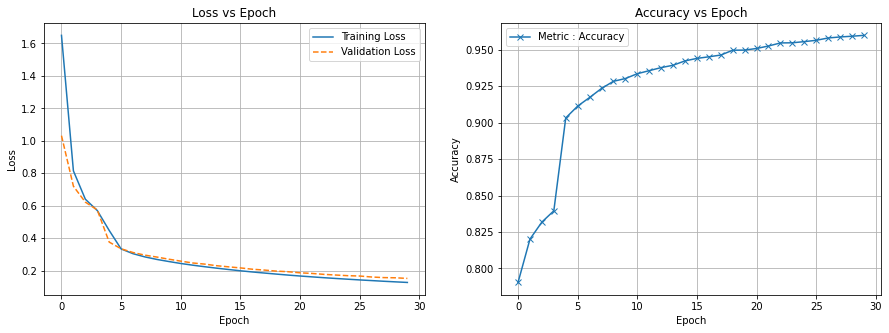

In [9]:
fig = plt.figure(figsize=(15,5))

# ===== Loss ===== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(hist_epoch, hist_train_loss, label='Training Loss')
ax1.plot(hist_epoch, hist_val_loss, '--', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()
ax1.set_title('Loss vs Epoch')

# ===== Metric : Accuracy ===== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(hist_acc_epoch, hist_acc, marker='x', label='Metric : Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()
ax2.set_title('Accuracy vs Epoch')

plt.show()